In [28]:
%config Completer.use_jedi = False

## import required libraries

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)


import dash
import dash_core_components as dcc 
import dash_html_components as html 
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle

## population data 

[source: Istat](dati.istat.it/Index.aspx?QueryId=18460)

In [112]:
df_pop_orig = pd.read_csv('./data/population.csv')

note per il recupero dati:
- ITTER107: 
-- lunghezza 2 = nazionale
-- lunghezza 4 = regione
-- lunghezza 5 = provincia
- Sesso = totale
- Età = totale
- Stato civile = totale



In [113]:
df_pop_orig['Tipo territorio'] = df_pop_orig.apply(lambda x:'Italia'    if len(x[0]) == 2 else \
                                                            'Regione'   if len(x[0]) == 4 else \
                                                            'Provincia' if len(x[0]) == 5 else \
                                                            'Altro', axis = 1)

In [117]:
df_popolazione = df_pop_orig.query("Sesso == 'totale' and Età == 'totale' and `Stato civile` == 'totale' and `Tipo territorio` != 'Altro'")[["Territorio", "Tipo territorio", "Value"]]
df_popolazione = df_popolazione.rename(columns={'Value': 'Popolazione'})

In [6]:
dati_nazionali = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
dati_regioni   = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
dati_province  = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'

In [7]:
feat_nazionali = ['data', 'ricoverati_con_sintomi', 'terapia_intensiva',
            'totale_ospedalizzati', 'isolamento_domiciliare',
            'totale_positivi', 'variazione_totale_positivi', 'nuovi_positivi',
            'dimessi_guariti', 'deceduti', 'totale_casi','tamponi']
feat_regioni = ['data', 'denominazione_regione', 'lat','long','ricoverati_con_sintomi','terapia_intensiva',
            'totale_ospedalizzati', 'isolamento_domiciliare',
            'totale_positivi', 'variazione_totale_positivi', 'nuovi_positivi',
            'dimessi_guariti', 'deceduti', 'totale_casi','tamponi']
feat_province = ['data', 'denominazione_provincia', 'sigla_provincia','lat','long', 'totale_casi']

In [8]:
def get_data_from_url(url, features):
    tmp_df = pd.read_csv(url)
    tmp_df['data'] = pd.to_datetime(tmp_df['data']).dt.date
    tmp_df = tmp_df[features]
    return tmp_df
    

In [99]:
df_nazionali = get_data_from_url(dati_nazionali, feat_nazionali)
df_regioni   = get_data_from_url(dati_regioni,   feat_regioni)
df_province  = get_data_from_url(dati_province,  feat_province)

In [100]:
df_nazionali.to_csv('./data/nazionali.csv', index=False)
df_regioni.to_csv('./data/regioni.csv', index=False)
df_province.to_csv('./data/province.csv', index=False)



In [35]:
df_nazionali=pd.read_csv('./data/nazionali.csv')
# df_regioni.to_csv('./data/regioni.csv', index=False)
# df_province.to_csv('./data/province.csv', index=False)

In [36]:
df_nazionali['data'] = pd.to_datetime(df_nazionali['data']).dt.date

In [37]:
df_nazionali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   data                                    387 non-null    object 
 1   stato                                   387 non-null    object 
 2   ricoverati_con_sintomi                  387 non-null    int64  
 3   terapia_intensiva                       387 non-null    int64  
 4   totale_ospedalizzati                    387 non-null    int64  
 5   isolamento_domiciliare                  387 non-null    int64  
 6   totale_positivi                         387 non-null    int64  
 7   variazione_totale_positivi              387 non-null    int64  
 8   nuovi_positivi                          387 non-null    int64  
 9   dimessi_guariti                         387 non-null    int64  
 10  deceduti                                387 non-null    int64 

In [38]:
last_date = (df_nazionali['data'].max() -  df_nazionali['data'].min()).days

In [40]:
first_date = df_nazionali['data'].min()
last_date = df_nazionali['data'].max()
delta_t = (last_date - first_date).days

In [43]:
val0 = 10
val1 = 30

In [58]:
bottom = first_date + pd.Timedelta(10, unit='days')

In [59]:
first_date

datetime.date(2020, 2, 24)

In [60]:
bottom

datetime.date(2020, 3, 5)

## correzione denominazione province e regioni per allineamento tra i due dataset

In [93]:
# province

In [120]:
prv_dpc = list(df_province['denominazione_provincia'].unique())

prv_istat = list(df_popolazione.query("`Tipo territorio` == 'Provincia'")["Territorio"])

In [121]:
set(prv_dpc).difference(set(prv_istat))

{'Fuori Regione / Provincia Autonoma', 'In fase di definizione/aggiornamento'}

In [ ]:
sorted(prv_istat)

In [119]:
# correzione di alcune differenze tra le denominazioni dei territori
## provincia di Aosta
Aosta = df_popolazione[(df_popolazione["Territorio"] == "Valle d'Aosta / Vallée d'Aoste")].copy()

Aosta['Territorio'] = 'Aosta'
Aosta['Tipo territorio'] = 'Provincia'

df_popolazione = pd.concat([df_popolazione, Aosta], axis=0)
## provincia di Massa Carrara
df_popolazione.loc[(df_popolazione["Territorio"] == "Massa-Carrara"), "Territorio"] = "Massa Carrara"
## provincia di Bolzano
df_popolazione.loc[(df_popolazione["Territorio"] == "Bolzano / Bozen"), "Territorio"] = "Bolzano"

In [94]:
## le 'Fuori Regione / Provincia Autonoma', 'In fase di definizione/aggiornamento' sono computate nei dati regionali, ma dovranno essere esclusi dai dati provinciali

In [95]:
# regioni

In [124]:
reg_dpc = list(df_regioni['denominazione_regione'].unique())
reg_istat = list(df_popolazione.query("`Tipo territorio` == 'Regione'")["Territorio"])

set(reg_dpc).difference(set(reg_istat))

set()

In [123]:
# correzioni
## regione Friuli
df_popolazione.loc[(df_popolazione["Territorio"] == "Friuli-Venezia Giulia"), "Territorio"] = "Friuli Venezia Giulia"
## Valle d'Aosta
df_popolazione.loc[(df_popolazione["Territorio"] == "Valle d'Aosta / Vallée d'Aoste"), "Territorio"] = "Valle d'Aosta"
# PA Bolzano
df_popolazione.loc[(df_popolazione["Territorio"] == "Provincia Autonoma Bolzano / Bozen"), "Territorio"] = "P.A. Bolzano"
# PA Trento
df_popolazione.loc[(df_popolazione["Territorio"] == "Provincia Autonoma Trento"), "Territorio"] = "P.A. Trento"



In [107]:
# salvo il dataframe della popolazione come .csv

In [189]:
df_popolazione.to_csv('./data/pop_cleaned.csv', index=False)

In [3]:
# reload da csv

In [ ]:
# da qui: codice da aggiungere alla app

In [5]:
df_pop = pd.read_csv("./data/pop_cleaned.csv")

### aggiungo colonna Popolazione ai tre dataset

In [12]:
df_nazionali['popolazione'] = df_pop.query("Territorio == 'Italia'")["Popolazione"][0]

df_province['popolazione'] = df_province.merge(df_popolazione,how='left', left_on='denominazione_provincia', right_on='Territorio')['Popolazione']

df_regioni['popolazione'] = df_regioni.merge(df_popolazione,how='left', left_on='denominazione_regione', right_on='Territorio')['Popolazione']

## Correzione: il numero cumulato di tamponi del 17.12.2020 sembra sbagliato (inferiore al giorno precedente). Lo sostituisco con NaN

In [53]:
df_nazionali.loc[297, "tamponi"] = np.nan

### aggiungo Nuovi tamponi ai dataset nazionali e regioni

In [54]:
df_nazionali['nuovi_tamponi'] = df_nazionali['tamponi'].diff()
df_nazionali.loc[0,'nuovi_tamponi'] = df_nazionali.loc[0,'tamponi']

df_regioni['nuovi_tamponi'] = df_regioni['tamponi'].diff()
df_regioni.loc[0,'nuovi_tamponi'] = df_regioni.loc[0,'tamponi']

### aggiungo Nuovi decessi ai dataset nazionali e regioni

In [59]:
df_nazionali['nuovi_decessi'] = df_nazionali['deceduti'].diff()
df_nazionali.loc[0,'nuovi_decessi'] = df_nazionali.loc[0,'deceduti']

df_regioni['nuovi_decessi'] = df_regioni['deceduti'].diff()
df_regioni.loc[0,'nuovi_decessi'] = df_regioni.loc[0,'deceduti']

## aggiungo media mobile settimanale decessi al dataset nazionale 

In [73]:
df_nazionali['decessi_media_mobile'] = df_nazionali["nuovi_decessi"].rolling(7).mean()

## prototipi di grafici

### grafico 1.1.1: nazionale - nuovi casi assoluti e % su tamponi (due linechart con assi disgiunti)

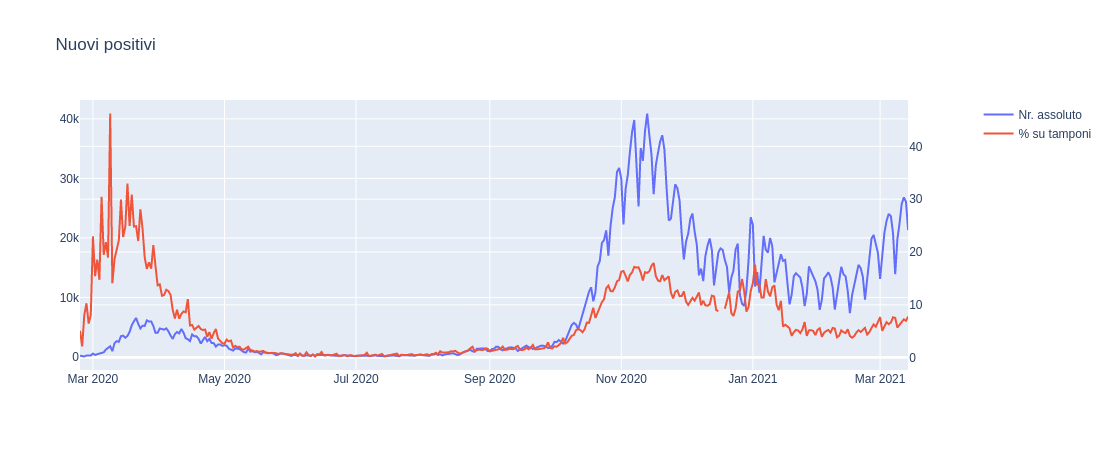

In [55]:
fig_1_1_1 = make_subplots(specs=[[{"secondary_y": True}]])

fig_1_1_1.add_trace(
   go.Scatter(x=df_nazionali["data"], y=df_nazionali["nuovi_positivi"], name='Nr. assoluto'), 
   secondary_y=False
)

fig_1_1_1.add_trace(
   go.Scatter(x=df_nazionali["data"], y=100*df_nazionali["nuovi_positivi"]/df_nazionali["nuovi_tamponi"], name='% su tamponi'),
   secondary_y=True
)

fig_1_1_1.update_layout(title_text='Nuovi positivi')

fig_1_1_1.show()

### grafico 1.1.2: nazionale - nuovi decessi e media mobile (linechart)

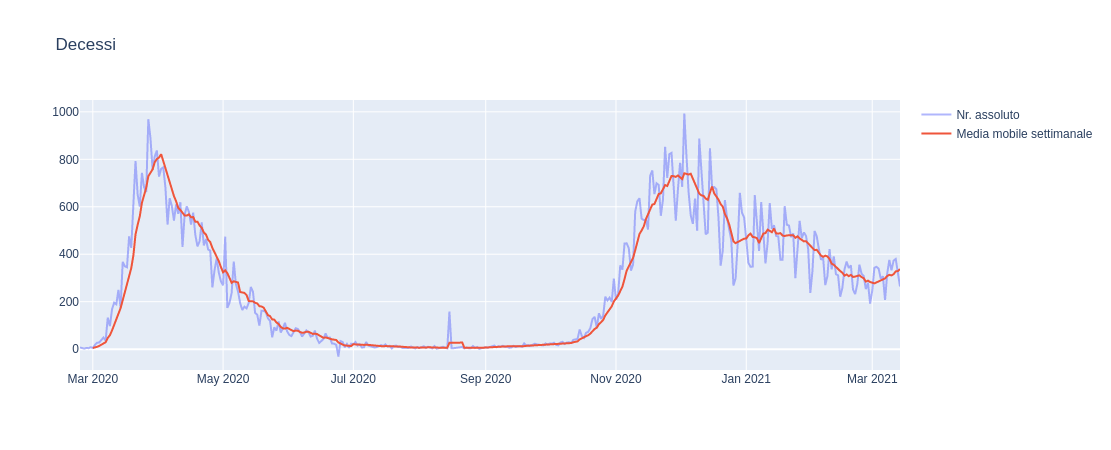

In [75]:
fig_1_1_2 = make_subplots()

fig_1_1_2.add_trace(go.Scatter(x=df_nazionali["data"], y=df_nazionali["nuovi_decessi"],name='Nr. assoluto',opacity=0.5))
fig_1_1_2.add_trace(go.Scatter(x=df_nazionali["data"], y=df_nazionali["decessi_media_mobile"],name='Media mobile settimanale'))
fig_1_1_2.update_layout(title_text='Decessi')

fig_1_1_2.show()

### grafico 1.1.3: nazionale - terapia intensiva e totale ospedalizzati (linechart + barchart)

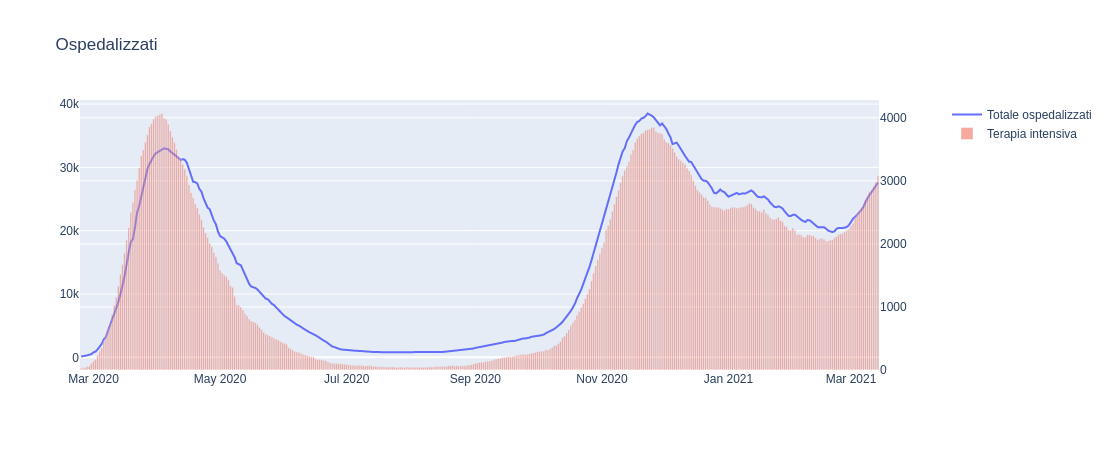

In [79]:
fig_1_2_1 = make_subplots(specs=[[{"secondary_y": True}]])

fig_1_2_1.add_trace(go.Scatter(x=df_nazionali["data"], y=df_nazionali["totale_ospedalizzati"],name='Totale ospedalizzati'), secondary_y=False)
fig_1_2_1.add_trace(go.Bar(x=df_nazionali["data"], y=df_nazionali["terapia_intensiva"],name='Terapia intensiva', opacity=0.5), secondary_y=True)
fig_1_2_1.update_layout(title_text='Ospedalizzati')

fig_1_2_1.show()

## KPIs: 
- delta nuovi casi rispetto giorno precedente
- % su tamponi
- delta decessi rispetto giorno precedente
- ultimo aggiornamento dati

In [88]:
delta_pos = 100*(df_nazionali.sort_values(by='data', ascending=False).iloc[0]['nuovi_positivi'] - df_nazionali.sort_values(by='data', ascending=False).iloc[1]['nuovi_positivi']) / df_nazionali.sort_values(by='data', ascending=False).iloc[1]['nuovi_positivi']
delta_pos


-18.214258307113806

In [89]:
perc_tamponi = 100 * df_nazionali.sort_values(by='data', ascending=False).iloc[0]['nuovi_positivi'] /  df_nazionali.sort_values(by='data', ascending=False).iloc[0]['nuovi_tamponi']
perc_tamponi

7.780162501916296

In [90]:
delta_dec = 100*(df_nazionali.sort_values(by='data', ascending=False).iloc[0]['nuovi_decessi'] - df_nazionali.sort_values(by='data', ascending=False).iloc[1]['nuovi_decessi']) / df_nazionali.sort_values(by='data', ascending=False).iloc[1]['nuovi_decessi']
delta_dec


-16.7192429022082

In [98]:
last_upd = df_nazionali['data'].max().strftime('%d/%m/%Y')
last_upd

'14/03/2021'

In [101]:
import datetime as dt

In [102]:
start_date = '24/02/2020'

In [105]:
data_da = dt.datetime.strptime(start_date,"%d/%m/%Y")

In [106]:
data_da

datetime.datetime(2020, 2, 24, 0, 0)

In [1]:
dd = 35.254418

In [10]:
print("{:+.2f}%".format(dd))

+35.25%
